<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Discontinuous Galerkin Method - 1D Elastic Wave Equation, Homogeneous cases</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* David Vargas ([@dvargas](https://github.com/davofis))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))

## Basic Equations

In [1]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib.pyplot as plt

from gll import gll
from lagrange1st import lagrange1st
from flux_homo import flux

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

### 1. Initialization of setup

In [2]:
# Initialization of setup
# --------------------------------------------------------------------------
c      = 2500          # acoustic velocity [m/s]
tmax   = 2.0           # Length of seismogram [s]
xmax   = 10000         # Length of domain [m]
vs     = 2500          # Advection velocity 
rho    = 2500          # Density [kg/m^3]
mu     = rho*vs**2     # shear modulus
N      = 4             # Order of Lagrange polynomials
ne     = 200           # Number of elements
sig    = 200           # Gaussian width
x0     = 5000          # x location of Gaussian 
eps    = 0.4           # Courant criterion
iplot  = 20            # Plotting frequency 
imethod = 'RK'      # 'Euler', 'RK'
#--------------------------------------------------------------------

# GLL points and integration weights
[xi,w] = gll(N)     # xi, N+1 coordinates [-1 1] of GLL points
                    # w Integration weights at GLL locations
# Space domain
le = xmax/ne        # Length of elements
ng = ne*N + 1

# Vector with GLL points  
k=0
xg = np.zeros((N+1)*ne)
for i in range(0, ne):
    for j in range(0, N+1):
        k += 1
        xg[k-1] = i*le + .5*(xi[j]+1)*le
        
x = np.reshape(xg, (N+1, ne), order='F').T

# Calculation of time step acoording to Courant criterion
dxmin = np.min(np.diff(xg[1:N+1]))
dt = eps*dxmin/vs    # Global time step
nt = int(np.floor(tmax/dt))

# Mapping - Jacobian
J  = le/2 # Jacobian
Ji = 1/J  # Inverse Jacobian

# 1st derivative of Lagrange polynomials
l1d = lagrange1st(N)   

### 2. Elemental Mass and Stiffness matrices

In [3]:
# Initialization of system matrices
# -----------------------------------------------------------------
# Elemental Mass matrix
M = np.zeros((N+1, N+1))
for i in range(0, N+1):
    M[i,i] = w[i]*J 
    
# Inverse matrix of M (M is diagonal!)
Minv = np.identity(N+1)
for i in range(0, N+1):
    Minv[i,i] = 1./M[i,i]
    
# Elemental Stiffness Matrix
K = np.zeros((N+1, N+1))
for i in range(0, N+1):
    for j in range(0, N+1):
            K[i,j] = w[j]*l1d[i,j] # NxN matrix for every element

### 3. Flux Matrices

In [4]:
# Inialize Flux relates matrices
# ---------------------------------------------------------------
Z = rho*vs
R = np.array([[Z, -Z], [1, 1]])
Rinv = np.linalg.inv(R)

Lm= np.array([[-c, 0], [0, 0]])
Lp= np.array([[0, 0] , [0, c]])

Ap = R @ Lp @ Rinv
Am = R @ Lm @ Rinv

A = np.array([[0, -mu], [-1/rho, 0]])

### 4.

<IPython.core.display.Javascript object>


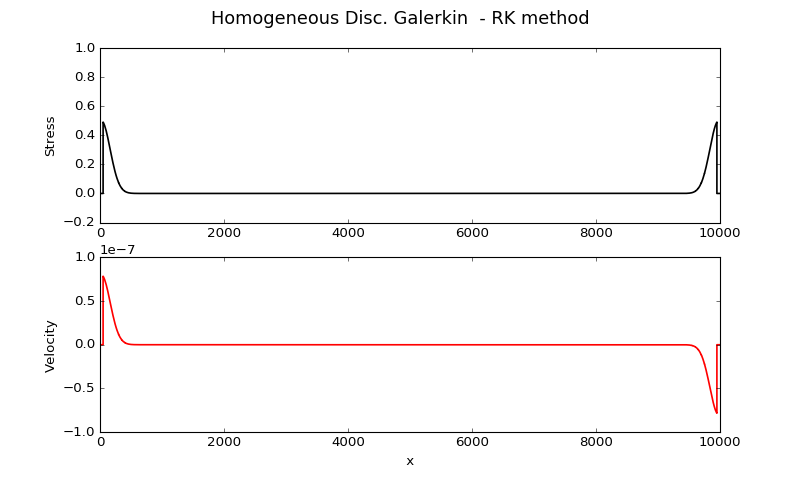

In [5]:
# DG Solution, Time extrapolation
# ---------------------------------------------------------------

# Initalize solution vectors
Q    = np.zeros([ne, N+1, 2])
Qa   = np.zeros([ne, N+1, 2])
Qnew = np.zeros([ne, N+1, 2])

k1 = np.zeros([ne, N+1, 2])
k2 = np.zeros([ne, N+1, 2])

Q[:,:,0] = np.exp(-1/sig**2*((x-x0))**2)
Qs = np.zeros(xg.size)  # for plotting
Qv = np.zeros(xg.size)  # for plotting 

# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
line1 = ax1.plot(xg, Qs, 'k', lw=1.5)
line2 = ax2.plot(xg, Qv, 'r', lw=1.5)  
ax1.set_ylabel('Stress')
ax2.set_ylabel('Velocity')
ax2.set_xlabel(' x ')
plt.suptitle('Homogeneous Disc. Galerkin  - %s method'%imethod, size=16)

plt.ion()   # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
for it in range(nt):            
    if imethod == 'Euler': # Euler    
        # Calculate Fluxes 
        Flux = flux(Q, N, ne, Ap, Am)        
        # Extrapolate each element using flux F 
        for i in range(1,ne-1):
            Qnew[i,:,0] = dt * Minv @ (-mu * K @ Q[i,:,1].T - Flux[i,:,0].T) + Q[i,:,0].T
            Qnew[i,:,1] = dt * Minv @ (-1/rho * K @ Q[i,:,0].T - Flux[i,:,1].T) + Q[i,:,1].T                

    elif imethod == 'RK':                  
        # Calculate Fluxes
        Flux = flux(Q, N, ne, Ap, Am)
        # Extrapolate each element using flux F 
        for i in range(1,ne-1):
            k1[i,:,0] = Minv @ (-mu * K @ Q[i,:,1].T - Flux[i,:,0].T)
            k1[i,:,1] = Minv @ (-1/rho * K @ Q[i,:,0].T - Flux[i,:,1].T)   

        for i in range(1,ne-1):
            Qnew[i,:,0] = dt * Minv @ (-mu * K @ Q[i,:,1].T - Flux[i,:,0].T) + Q[i,:,0].T 
            Qnew[i,:,1] = dt * Minv @ (-1/rho * K @ Q[i,:,0].T - Flux[i,:,1].T) + Q[i,:,1].T    

        Flux = flux(Qnew,N,ne,Ap,Am)

        for i in range(1,ne-1):
            k2[i,:,0] = Minv @ (-mu * K @ Qnew[i,:,1].T - Flux[i,:,0].T)
            k2[i,:,1] = Minv @ (-1/rho * K @ Qnew[i,:,0].T - Flux[i,:,1].T) 
            
        # Extrapolate       
        Qnew = Q + (dt/2) * (k1 + k2)
    else:
        raise NotImplementedError

    Q, Qnew = Qnew, Q

    # --------------------------------------   
    # Animation plot. Display solution            
    if not it % iplot: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l 

        # stretch for plotting
        k = 0
        for i in range(ne):
            for j in range(N+1):
                Qs[k] = Q[i,j,0]
                Qv[k] = Q[i,j,1] 
                k = k + 1
        # -------------------------------------- 
        # Display lines
        line1 = ax1.plot(xg, Qs, 'k', lw=1.5)
        line2 = ax2.plot(xg, Qv, 'r', lw=1.5)
        plt.gcf().canvas.draw()